Tutaj pokazałem przykład z wykorzystaniem API kompaktybilnego z scikit-learn

In [3]:
# inicjacja bibliotek oraz przestrzeni nazw
import pandas as pd
import numpy as np
import os

data_path = "E:\page_ds\LightGBM_step_by_step"
pict_path = os.path.join(data_path, r"foto")

MainData = pd.read_csv(os.path.join(data_path, "train.csv"))

#podział na cechy oraz zmienną celu
y = MainData['target'].copy()
X = MainData.drop(columns=['id','target']).copy()

#lista cech kategorialnych
X_cat_col = list(X.loc[:,X.dtypes!=np.number].columns)


for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')

Następnie inicjujemy przestrzeń parametrów i wrzucamy to do modelu. Tym razem nie dzielimy zbioru na część treningową i walidacyjną tylko korzystamy z całego dostępnego zestawu danych podzielonego krzyżowo  na 5 podzbiorów

In [1]:
from optuna.integration import LightGBMPruningCallback
import optuna
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score # dane są nisko niezbalansowane przez co powinniśmy rozpatrzyć losowanie warstwowe
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=128262)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

i trenujemy, dla przyśpieszenia 100 rundek

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=100)

In [5]:
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best params:
	n_estimators: 1000
	learning_rate: 0.21349560425607134
	num_leaves: 1380
	max_depth: 4
	min_data_in_leaf: 2800
	lambda_l1: 45
	lambda_l2: 75
	min_gain_to_split: 0.9290119245426975
	bagging_fraction: 0.8
	bagging_freq: 1
	feature_fraction: 0.9


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.9290119245426975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9290119245426975
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Accuracy for validation set: 0.8488
Accuracy for train set: 0.8545
Wartość parametru Gini na zbiorze walidacyjnym to: 0.7839
Wartość parametru Gini na zbiorze treningowym to: 0.7994

ROC Curve

Confusion Matrix


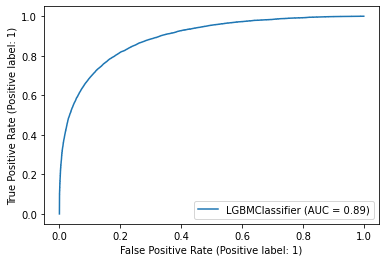

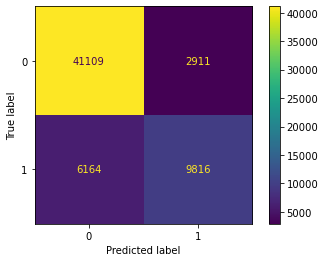

In [6]:
import matplotlib.pyplot as plt
import lightgbm as lgb
# dane są nisko niezbalansowane przez co powinniśmy rozpatrzyć losowanie warstwowe
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=128262)

# inicjalizujemy model na wymyślonych przeze mnie parametrach (PO BOŻEMU: tu powinny być parametry z Optuny!!!)
lgb_clf = lgb.LGBMClassifier(learning_rate=0.21349560425607134,
                             num_leaves=1380,
                             max_depth=4,
                             n_estimators=1000,
                             objective='binary',
                             min_data_in_leaf = 2800,
                             reg_alpha = 45,  #L1
                             reg_lambda = 75,  #L2
                             min_gain_to_split = 0.9290119245426975,
                             boosting_type ='gbdt',
                             bagging_fraction = 0.8,
                           #  bagging_freq = 1,
                             feature_fraction = 0.9,
                             #n_jobs=-1,
                             random_state=128262)

# uczymy model, korzystamy z API sklearn
lgb_clf.fit(X_train, y_train)

# przeliczamy skoringi na zbiorze testowym aby sprawdzić jakość modelu w rozumieniu interesujących mnie miar
y_hat = lgb_clf.predict(X_test)

auc_val = roc_auc_score(y_test, lgb_clf.predict_proba(X_test)[:, 1])
auc_train = roc_auc_score(y_train, lgb_clf.predict_proba(X_train)[:, 1])

print("Accuracy for validation set: {0:.4f}".format(accuracy_score(y_test, y_hat)))
print("Accuracy for train set: {0:.4f}".format(accuracy_score(y_train, lgb_clf.predict(X_train))))

print("Wartość parametru Gini na zbiorze walidacyjnym to: {0:.4f}".format(2*auc_val-1)) # Gini = 2*AUC-1
print("Wartość parametru Gini na zbiorze treningowym to: {0:.4f}".format(2*auc_train-1)) # Gini = 2*AUC-1

print("\nROC Curve")
print(RocCurveDisplay.from_estimator(lgb_clf, X_test, y_test))
#RocCurveDisplay.from_estimator(lgb_clf, X_test, y_test)
#plt.savefig(os.path.join(pict_path, "3_ROC_cur_clf_scikit.png"), format="png" , dpi=300, facecolor="White")

print("\nConfusion Matrix")
#print(plot_confusion_matrix(xgb_clf, X_test, y_test))
cm = confusion_matrix(y_test, y_hat, labels=lgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lgb_clf.classes_)
print(disp.plot())
#wyk = disp.plot()
#plt.savefig(os.path.join(pict_path,"4_conf_matrix_clf_scikit.png"), format="png" , dpi=300, facecolor="White")
plt.show()

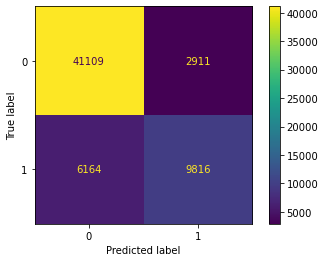

In [8]:
wyk = disp.plot()
plt.savefig(os.path.join(pict_path,"4_conf_matrix_clf_scikit.png"), format="png" , dpi=300, facecolor="White")